This is the first notebook of a series of kernels I'm going to publish on this dataset in which I want to learn and teach by exploring Machine learning to it's fullest by reading books like [100-page ml book](http://themlbook.com/) and [Hands-on Machine Learning with Scikit learn and Tensorflow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646) and also papers. If you like to follow along or see my content I publish, subscribe to my YouTube channel or follow me on Kaggle. Let's start 🤓 😎

## Question: Why do we care about missing values?

So many of the most famous algorithms(e.g. all the Scikit learn algorithms) can't operate when there are missing values in the dataset. Also We cannot get accurate results when an important feature is missing.

The least that we can do is to either get rid of these features or fill them with something that can be similar to the value that had to be present or something that is a typical value for that field, so we can both have that feature and let the algorithm use other features to distinguish this example from others and make a prediction based on whatever else we have. So let's see what we can do for them with stories...

In [ ]:
%%HTML
<a id="Analysis"></a>
<center>
<iframe width="700" height="315" src="https://www.youtube.com/embed/FqxllA_HCR8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" style="position: relative;top: 0;left: 0;" allowfullscreen ng-show="showvideo"></iframe>
</center>


In [ ]:
import numpy as np
import pandas as pd

# for vis
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder


## How to handle them? How to know what to do with them?!

 When handling these null values we have to divide them into three categories. [Reference](https://cjasn.asnjournals.org/content/9/7/1328.abstract)
 
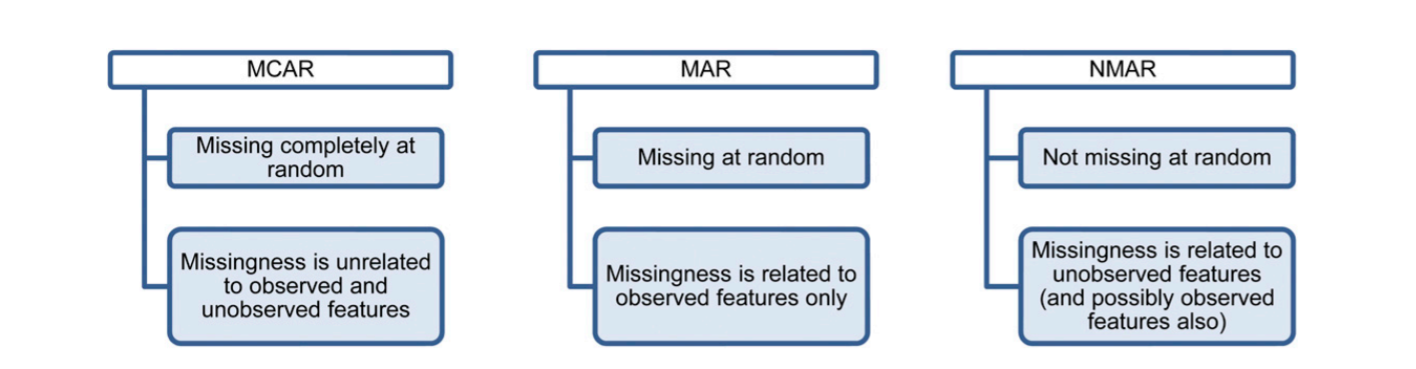

**Missing Completely at Random(MCAR)**: This means that there is no relationship between the missing values themselves and any other feature or observation in the dataset. These are just missing randomly and without any pattern. Like when a questionnaire is lost or some parts of a survey paper are soaked and you cannot read what it's saying. Therefore we can simply ignore them.

**Missing at Random(MAR)**: Means there is a pattern and relationship between the missing values and the observed values, like when the survey is about mental and physical health, male participants are less likely to know their waist circumference or boob size. We can again ignore these missing values and drop the feature or examples from our dataset. In this case we say that missing values are only related to the observed features(gender).

**Missing Not at Random(MNAR)**: Well, this is a missing value that cannot and should not be ignored. We have to model and see when were the values missing and what was the reason for it. Like in the previous scenario, men might not answer questions about depression because of their depression. In this case we say that the missing values are related to themselves(depression) as well as to the observed features(gender).

<div class="alert alert-info" role="alert">
Read more:
<h2>Why do men kill themselves more than women?</h2>
<a href="https://en.wikipedia.org/wiki/Gender_differences_in_suicide" style="color:Black;">Suicide gender paradox</a>. Male suicide rates are explained in terms of traditional gender roles. Male gender roles tend to emphasize greater levels of strength, independence, risk-taking behavior, economic status, and individualism. Reinforcement of this gender role often prevents males from seeking help for suicidal feelings and depression.</div>


Now that we understood how important it is to take care of the data and look for signs of trouble, even in the null values, let's import the dataset, give them name to distinguish them later and make a concatinated dataframe that can show us what's in each very easily.

You can learn about the code and packages more in the second video. Ask me questions in here or in the comments on YouTube.

In [ ]:
path = '../input/house-prices-advanced-regression-techniques'
train = pd.read_csv(path + r'/train.csv', )
test = pd.read_csv(path + r'/test.csv')

train.name = 'train'
test.name = 'test'

# keeping testing id for submission in the future
test_id = test.Id
for df in [train, test]:
    df.drop(columns = ['Id'], inplace = True)
    
df_concat = pd.concat([train, test], axis = 0).reset_index(drop = True)
df_concat.name = 'both dfs'

df_concat.loc[:train.shape[0], 'which'] = 'train'
df_concat.loc[train.shape[0]:, 'which'] = 'test'

In [ ]:
print('Number of training examples: ', train.shape[0])
print('Number of testing examples: ', test.shape[0])
print('Testing set to the whole: ', round(test.shape[0]/df_concat.shape[0], 2))
print('Number of features:', test.shape[1])
f_y = min(df_concat['YrSold'])
f_m = min(df_concat[df_concat['YrSold'] == f_y].MoSold)
print('Selling records start from {}\{}'.format(f_y, f_m))

In this Kernel I will focus on null values but just to have an idea of the dataset, you can play with the plots bellow to get a feeling for the data. You can add fields that you want to analyze to the list in the second plot and plot their distribution in the testing and training set.

In [ ]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Bar(name='Sum', x=train.groupby('YrSold').sum().index
           , y = train.groupby('YrSold').sum().SalePrice),row=1, col=1
)
fig.add_trace(
    go.Bar(name='Count', x=train.groupby('YrSold').count().index,
           y=train.groupby('YrSold').count().SalePrice),row=1, col=2
)

fig.update_yaxes(title_text="sum", row=1, col=1)
fig.update_yaxes(title_text="count", row=1, col=2)
fig.update_xaxes(title_text="year", row=1, col=1)
fig.update_xaxes(title_text="year", row=1, col=2)
fig.update_layout(title_text="How Much?How Many?", height=500)
fig.show()


In [ ]:
features = ['OverallQual', 'MoSold'] # add the name of the column to this list

sns.set_style('whitegrid')
for feature in features:    
    sns.catplot(x=str(feature), kind="count", palette="PuRd_r",
                data=df_concat, col = "which")

# Let's Detect what is missing 🤨

In [ ]:
def detect_nulls(*args, n=30):
    df_null = pd.DataFrame()
    for df in args:
        df_null_n = df.isnull().sum()
        df_null_n = pd.DataFrame(np.c_[df_null_n, np.round(df_null_n/len(df) *100, 2)],
                                 columns=['count', 'percentage'], index = df_null_n.index)
        
        df_null_n.sort_values(by = df_null_n.columns[0], ascending=False, inplace = True)
        
        df_null_n.columns = pd.MultiIndex.from_product([[str(df.name)], df_null_n.columns])
        df_null = pd.concat([df_null, df_null_n], axis = 1)
   
    df_null = df_null.loc[[i for i in df_null.index if (df_null.loc[i, :] != 0).any() & (i not in ['SalePrice', 'which'])]]
    num_nulls = len(df_null)
    
    print('How many features had at least one null value?',num_nulls)
    print('{} most empty features of all:'.format(n))
    return df_null[:n]

In [ ]:
df_null = detect_nulls(df_concat, train, test, n = 80) 
df_null

Now we'll plot the values to have a better understanding. Just make sure to click on the legends on the top right to look at the values related to each dataset respectively.

In [ ]:
# making our dataset ready for vis
df_null = detect_nulls(df_concat, train, test, n = 81).reset_index().melt(id_vars = ['index'])
# if you have question how this works just 
# print the df_null and you'll notice how it's done

fig = px.bar(x = df_null.loc[df_null.variable_1 == 'percentage','index'],
             y = df_null.loc[df_null.variable_1 == 'percentage'].value,
             text = df_null.loc[df_null.variable_1 == 'count'].value,
             title = 'Precentage of missing values per feature and dataset',
             color = df_null.loc[df_null.variable_1 == 'count'].variable_0)
fig.update_xaxes(title = 'Feature')
fig.update_yaxes(title = 'Percentage')
fig.show()

# What do they represent and What can we do?

## 1. simplest approach: Dropping either the examples or columns with null value 🏌🏻‍

As we can see in the table, 34 columns have null values.
if we drop all these null values, the model that we make at the end will be a robust. Although, when the percentage of missing values is high, our model will preform poorly due to the information loss. In our case there are Some features like PoolQC (Pool Quality) and MiscFeatures(Miscellaneous features) that are mostly empty and as we can see in the data description, null in these features simply mean there is no pool or extra feature in the property. So we should either set these null values to zero  and see whether their presence makes any difference, or simply remove them and get more memory and speed for our algorithms.

**But to drop or not to drop?**🤦‍

There are certain questions that can help us with this definition. In this competition, we want to predict the price at which a house is sold. So one way to see if having this feature makes any difference, is by plotting houses with pool and without pool against their sales price. Does having pool mean any specific thing here? What about miscellaneous features and Alley?

In [ ]:
features = ['PoolQC', 'MiscFeature', 'Alley']
orders = [["None", "Fa", "Gd", "Ex"], None,None]

for i, feature in enumerate(features):
    
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = sns.stripplot(x=feature, y="SalePrice", data=train.fillna("None"),
                       order=orders[i], size = 8)
    ax.set_title('number {} most empty feature!'.format(i+1))

As for the PoolQual, we can see that there is no very obvious trend going on here. In fact even if we just put all these houses in one category (having pool) and all others in another(No pool) we won't get anything special either. Additionally, because there is only very small evidence that having pool can have an impact on the price and testing set has even less houses that have pool, this field will be ignored specially when we use algorithms like Lasso. So our best bet is to just simply remove this feature and go onto other fields.

In other fields such as Alley or Miscellaneous features, I had the intention of removing, though due to the number of examples that had these features available, I thought I'll leave them be and see what will happen. After constructing the model you can decide what to do by experimenting more.
## 2. Filling missing values

I remember when I started working on this dataset on Kaggle, I read about a couple of different ways that you could still have the feature by filling them in with some assumed values. Some of these ways are naïve, some are complicated and some take time and are manually done.  In this section we'll look at all and see which ones work best in which cases.

### Filling with 0 and None 👌
 
when we look at fields like "GarageType", "GarageQual" or "BsmtQual", we see that these are fields related to a property in a house like Garage or Basement. Well, what would happen if there was no garage or basement? the fields would be value of null as the data description tells us. (NA = No Garage) So for not having null, we simply fill them all with None.

This is also True for the "GarageArea", "GarageCars", "BsmtFinSF1" as we fill them with 0.

In [ ]:
df_concat.drop(columns = ['PoolQC'], inplace = True)

In [ ]:
# fields about the Garage
for field in ['GarageType', 'GarageFinish','GarageQual', 'GarageCond',
              'BsmtFinType1','BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
              'BsmtFinType2','MiscFeature','Alley','Fence','FireplaceQu',
               'MasVnrType' ] :
    df_concat[field].fillna('None',inplace=True)
    
for field in ['MasVnrArea','BsmtFullBath','BsmtHalfBath'
              ,'BsmtFinSF1','GarageCars','GarageArea','TotalBsmtSF',
             'BsmtUnfSF','BsmtFinSF2','GarageYrBlt','TotalBsmtSF']:
    df_concat[field].fillna(0,inplace=True) 



### Forward fill and backward fill 👈 👉

personally, I  rarely use this method as it is very naïve and it only works if you have an apparent pattern in your data. For example, you can use this approach if your data can be sorted by date and you  want to fill the null values in the date column with the previous or the next observation (which is called Last Observation Carried Forward -LOCF). But in our data here, I prefer not to use this method.

### filling with Mean and Median 🙌

Filling with mean(for numeric values) or median(for categorical) is one of the methods that is very straight forward and simple in which we only give all the missing values, something normal and typical to prevent dropping them and also letting other features decide how we should distinguish these examples from the others. So we try to predict the label by relying mostly on the other features. We can use tools like the simple imputer from Scikit learn library to do the following.

But before using this method, here is one important question:

<div class="alert alert-success" role="alert">
<center><h2>Can we use the testing set to find out how we should impute the null values?</h2></center>
    
    
If you look at the discussions panel in this competition, you'll find that so many people have argued that you should only use the training examples to, for example, find the mean of a column's values and save this value to use it on the testing set too. As they say, using both the training and testing datasets to find the mean is called data leakage. I was myself a little confused and thought that we should be using both datasets to have a better mean value. So I did a little research to see what is the best approach.

In the <a href="https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291" style="color:Blue;">Hands-On Machine Learning with Scikit-Learn and TensorFlow book</a>, the author suggests the following:
    
    
<blockquote style="color:Black;">[...] you should compute the median value on the training set, and use it to fill the missing values in the training set, but also don't forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data. </blockquote>
    
So he said that we shouldn't use both. But in fact, in a Kaggle competition, where you have both your training and testing set ready and fixed and no new examples are come from new experiments or records, we do not need to take this into account. We can calculate the mean or median globally without being concerned about new examples. You can read about this <a href="https://stats.stackexchange.com/questions/320085/when-imputing-missing-values-in-a-test-set-should-the-new-values-come-from-the" style="color:Blue;"> more on stackoverflow.</a></div>

So now we want to see how we can use a naïve approach and turn it into something meaningful. Let's look at two features "LotFrontage" and "MSZoning":

* ***MSZoning***: Identifies the general zoning classification of the sale. (Its values are; Agriculture, Commercial, Industrial, etc.)
* ***LotFrontage***: Linear feet of street connected to property 
* ***Electrical***: Electrical system(Standard Circuit, Mixed, etc.)

The irst two features are aspects of a property that are not only related to one specific example, but instead a feature common among a neighborhood. So hopefully we can decide on its value based on how other houses in that neighborhood are. Are they commercial or agriculture? How big are this area's streets? 

Also if we group all the examples by their neighborhood and Electrical Systems, we see that most houses in one area are using the same Electrical system, so we can use this approach for this feature too. **But we will tackle these values with other methods so you'll have a wide range of tools available at your hand and see which works best.**


In [ ]:
df_concat['LotFrontage'] = df_concat.groupby('Neighborhood')['LotFrontage']\
                          .transform(lambda x: x.fillna(x.mean()))
for feature in ['MSZoning', 'Electrical']:
    df_concat[feature] = df_concat.groupby('Neighborhood')[feature]\
                        .transform(lambda x: x.fillna(x.mode()[0]))
    
# There's only one null in each of the following that we fill
# with the most frequent
for field in ['SaleType','Exterior1st','Exterior2nd',]:
    df_concat[field].fillna(df_concat[field].mode()[0],inplace=True)

**Manually handling each column**

There are certain columns that can be easily filled without much hard work. "Functional" and "KitchenQual" are two features that have only 2 and 1 missing values that can be filled with the assumption of them being like most other typical houses. This assumption won't hurt our model when our missing values are very much smaller than the observed values.

In [ ]:
df_concat.Functional.fillna('Typ',inplace=True)
df_concat.KitchenQual.fillna('TA',inplace=True)

In [ ]:
detect_nulls(df_concat)

The only thing that is left is Utilities. This column tells us what utilities are available and its unique values and their fequency are shown bellow. As we can see there is no more than one different value in this field which shows how useless this field is for distinguishing between examples. We don't want unpredictive features in our dataset so we simply drop the whole column.

In [ ]:
df_concat.Utilities.value_counts()

In [ ]:
df_concat.drop(columns = ['Utilities'], inplace = True)

## 3. Use a model that is compatible with missing values

There are some algorithms that are robust to missing values, meaning that when you run a model, they will ignore them or not take them into account. For example KNN(the k nearest neighborhood algorithm) can ignore the missing feature when it's calculating the distance between examples. The Naïve Bayes algorithm can ignore the missing examples when calculating a probability for a special class.

But if you're using scikit learn you don't have this option of not filling or dropping null values because the algorithms can't simply handle null values.

## 4. Categorical and numeric values and Using an algorithm for missing values

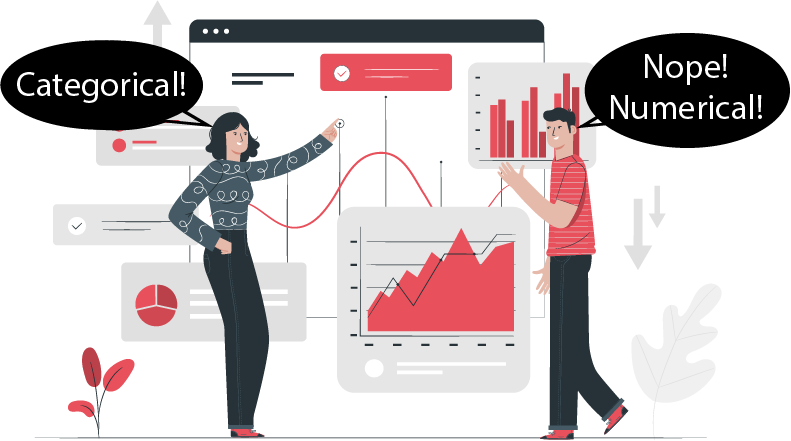
In order to construct a model we have to do a little bit of preprocessing to help the model understand our features. In general, we have two types of data; numerical and categorical.

- numeric values are like the size of a house, how many stories it has and so on.
- categorical values that split into two groups:
ordinal variables (categorical data with a certain order, like the quality of household material that starts from "Poor" and ends with "Excellent")
nominal variables (categorical data with no specific order, like different types of roof material that can be "Metal", "Roll", "Gravel" and etc.)

As you may expect we don't change anything about numeric ones as they can be easily understood by our mode. But we have some tools like One-Hot-encoder or Label-Encoder in Scikit-learn that help us change these variables into a numerical format that's readable for our models.

Some categorical data like CentralAir(yes and no values) and YrSold(starting from 1872 to 2010) are already in numbers so the label encoder can detect the order and give them digits starting from 0(e.g. the first year appearing in the dataset).
But some other features, like the KitchQual, don't have such advantage because they're in letters(the quality can be Poor, Fair, Typical, Good and Excellent). For that we can simply type the order in a list and then use an Ordinal Encoder to encode each variable based on them.
Also there are some categorical variables that don't need any change as they are in order and in a satisfying rage. like the OverallQual(overal quality) that is between 1 and 10 and the MoSold(month sold) that is between 1 and 12.


In [ ]:
### ordinal that labelencoder detects their orders like years...
ordinal_fields_with_labelencoder=['LandSlope','YearBuilt','YearRemodAdd',
                                  'CentralAir','GarageYrBlt','PavedDrive',
                                  'YrSold']

### ordinal with labelencoder...
for field in ordinal_fields_with_labelencoder:
    le = LabelEncoder()
    df_concat[field] = le.fit_transform(df_concat[field].values)
    

In [ ]:
features_that_are_already_ordinal = ['OverallQual','OverallCond','MoSold',
                                     'FullBath','KitchenAbvGr','TotRmsAbvGrd']


In [ ]:
### ordinal features that need to be sorted with ordinal encoder...
fields_that_need_to_be_ordered = [
              'MSSubClass','ExterQual','LotShape','BsmtQual','BsmtCond',
              'BsmtExposure','BsmtFinType1', 'BsmtFinType2','HeatingQC',
              'Functional','FireplaceQu','KitchenQual', 'GarageFinish',
              'GarageQual','GarageCond','Fence'
                                    ]
for field in  fields_that_need_to_be_ordered:
    df_concat[field] = df_concat[field].astype(str)


orders=[#msclass
    ['20','30','40','45','50','60','70','75','80','85', '90','120','150','160','180','190'],
    #ExterQual
    ['Po','Fa','TA','Gd','Ex'],
    #LotShape
    ['Reg','IR1' ,'IR2','IR3'],
    #BsmtQual
    ['None','Fa','TA','Gd','Ex'],
    #BsmtCond
    ['None','Po','Fa','TA','Gd','Ex'],
    #BsmtExposure
    ['None','No','Mn','Av','Gd'],
    #BsmtFinType1
    ['None','Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ' ],
    #BsmtFinType2
   ['None','Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ' ],
    #HeatingQC
    ['Po','Fa','TA','Gd','Ex'],
    #Functional
   ['Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],
    #FireplaceQu
    ['None','Po','Fa','TA','Gd','Ex'],
    #KitchenQual
    ['Fa','TA','Gd','Ex'],
    #GarageFinish
    ['None','Unf','RFn','Fin'],
    #GarageQual
    ['None','Po','Fa','TA','Gd','Ex'],
    #GarageCond
    ['None','Po','Fa','TA','Gd','Ex'],
    #PoolQC
    #['None','Fa','Gd','Ex'],
    #Fence
    ['None','MnWw','GdWo','MnPrv','GdPrv'] ]
   

### ordinal features with specific order.....
for i in range(len(orders)):

    ord_en = OrdinalEncoder(categories = {0:orders[i]})
    df_concat.loc[:,fields_that_need_to_be_ordered[i]] = ord_en.fit_transform(df_concat.loc[:,fields_that_need_to_be_ordered[i]].values.reshape(-1,1))


In [ ]:
numerical_cols = df_concat._get_numeric_data().columns
categorical_cols = list(set(df_concat.columns) - set(numerical_cols))

# all the following features are categorical without any order
# then we infer that we can use get_dummies
categorical_cols

In [ ]:
df_concat=pd.get_dummies(df_concat.drop(columns = ['which', 'SalePrice']))
df_concat.head()

## Now the data is literary ready to use for any Scikit learn model!!!

Ofcourse you can be content with what you have now, but if you want to see a few more tools and tricks, stick around for this section ;) For filling null values we also have the following packages. The knn imputer that looks at all the examples and tries to impute the closest value to the one that is missing. Also we have enable_iterative_imputer which can use different algorithms to predict the missing ones. For each you can use the code bellow to impute whatever column in our dataset after we've converted all features into digits. Just make sure to run the first cells to re-import the dataset and not the already imputed dataset.

In [ ]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputed_df = pd.DataFrame(imputer.fit_transform(df_concat))
imputed_df.columns = df_concat.columns
imputed_df.name = 'imputed'
detect_nulls(imputed_df)

In [ ]:
from sklearn.experimental import enable_iterative_imputer  

from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]

imputer = IterativeImputer(random_state=0, estimator=estimators[1])
imputer.fit(df_concat)
imputed_df = pd.DataFrame(imputer.transform(df_concat))
imputed_df.columns = df_concat.columns
imputed_df.name = 'imputed'
detect_nulls(imputed_df)

I hope this kernel gave you the intuition and tools you need for your own dataset and projects. Make sure to upvote if it was hopeful or keep along with these series in which I try to explore machine learning with the house price dataset!